# <center>Anomaly Detection</center>


In [ ]:
#======================== using of training and testing and data augmetation with our model 

In [ ]:
#======================== using of training and testing and No augmetation with our model 

In [3]:
from keras.preprocessing.image import ImageDataGenerator
import os
import cv2
import pickle
from tqdm import tqdm
import numpy as np
import random

test_dir = '/kaggle/input/ucf-crime-dataset/Test'
train_dir = '/kaggle/input/ucf-crime-dataset/Train'

# Define the categories and labels
categories_labels = {'Fighting': 0, 'Shoplifting': 1, 'Abuse': 2, 'Arrest': 3, 'Shooting': 4, 'Robbery': 5, 'Explosion': 6}

def load_data(base_dir, categories_labels):
    data = []
    
    # Go through each category
    for category, label in categories_labels.items():
        # The path to the category directory
        category_dir = os.path.join(base_dir, category)

        # Make sure the directory exists
        if os.path.isdir(category_dir):
            # Go through each file in the directory
            for filename in tqdm(os.listdir(category_dir), desc=f"Loading {category}"):
                # Make sure the file is an image
                if filename.endswith(".jpg") or filename.endswith(".png"):
                    # The path to the image
                    image_path = os.path.join(category_dir, filename)

                    try:
                        # Load the image
                        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

                        # Resize the image
                        image = cv2.resize(image, (50, 50))

                        # Reshape the image to 4D array (ImageDataGenerator requires 4D array)
                        image = image.reshape((1,) + image.shape + (1,))

                        # Add the image and its label to the data
                        data.append([image, label])
                    except Exception as e:
                        print(f"Error loading image {image_path}: {e}")

    return data

# Load the training and test data
training_data = load_data(train_dir, categories_labels)
test_data = load_data(test_dir, categories_labels)

# Combine the training and test data
total_data = training_data + test_data

print(f"Loaded {len(total_data)} images.")


Loading Explosion: 100%|██████████| 6510/6510 [00:58<00:00, 111.63it/s]

Loaded 189869 images.


In [4]:
import numpy as np
from sklearn.model_selection import train_test_split
from keras.utils import np_utils
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, LeakyReLU
from keras.layers import LSTM, TimeDistributed, Conv1D, MaxPooling1D
from keras.layers import Dense, Dropout, Flatten
from keras.layers import concatenate
from keras.utils.vis_utils import plot_model
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger
import time


# Initialize lists to store the images and the labels
images = []
labels = []

# Go through each image and its label in the total_data
for image, label in total_data:
    images.append(image)
    labels.append(label)

# Convert the lists into numpy arrays
images = np.array(images)
labels = np.array(labels)
print(images.shape)

# Reshape images for LSTM
images_lstm = images.reshape(images.shape[0], -1, 1)  # Added third dimension for features

# Set a seed for reproducibility
seed = 42

# Split the data into training and testing sets for CNN
train_images_cnn, test_images_cnn, train_labels_cnn, test_labels_cnn = train_test_split(images, labels, test_size=0.1, random_state=seed)

# Split the data into training and testing sets for LSTM
train_images_lstm, test_images_lstm, train_labels_lstm, test_labels_lstm = train_test_split(images_lstm, labels, test_size=0.1, random_state=seed)

# Convert labels to categorical for CNN
train_labels_cnn = np_utils.to_categorical(train_labels_cnn, len(categories_labels))
test_labels_cnn = np_utils.to_categorical(test_labels_cnn, len(categories_labels))

# Convert labels to categorical for LSTM
train_labels_lstm = np_utils.to_categorical(train_labels_lstm, len(categories_labels))
test_labels_lstm = np_utils.to_categorical(test_labels_lstm, len(categories_labels))

# Remove the second dimension from your data
train_images_cnn = np.squeeze(train_images_cnn, axis=1)
test_images_cnn = np.squeeze(test_images_cnn, axis=1)


# CNN Model
model_CNN = Sequential()
model_CNN.add(Conv2D(64, kernel_size=(3, 3), padding='same', input_shape=(50, 50, 1)))
model_CNN.add(LeakyReLU(alpha=0.1)) 
model_CNN.add(MaxPooling2D((2, 2), padding='same')) 
model_CNN.add(Dropout(0.25))
model_CNN.add(Conv2D(128, (3, 3), padding='same')) 
model_CNN.add(LeakyReLU(alpha=0.1)) 
model_CNN.add(MaxPooling2D(pool_size=(2, 2), padding='same')) 
model_CNN.add(Dropout(0.25))
model_CNN.add(Conv2D(256, (3, 3), padding='same'))
model_CNN.add(LeakyReLU(alpha=0.1))
model_CNN.add(MaxPooling2D(pool_size=(2, 2), padding='same')) 
model_CNN.add(Dropout(0.4))  
model_CNN.add(Flatten()) 
model_CNN.add(Dense(256)) 
model_CNN.add(LeakyReLU(alpha=0.1))            
model_CNN.add(Dropout(0.5)) 

# LSTM Model
model_lstm = Sequential()
model_lstm.add(LSTM(units = 8, return_sequences = True, input_shape = (2500, 1), activation='tanh'))
model_lstm.add(LSTM(units = 8, return_sequences = True))
model_lstm.add(Dense(4, activation='tanh'))
model_lstm.add(Dropout(0.2))
model_lstm.add(Flatten())

# Combine CNN and LSTM model
nb_classes = 7
combined = concatenate([model_CNN.output, model_lstm.output], axis=-1)
output = Dense(nb_classes, activation='softmax')(combined)
model_final = Model(inputs=[model_CNN.input, model_lstm.input], outputs=output)

# Plot and compile the model
plot_model(model_final, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

model_final.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Callbacks
csv_logger = CSVLogger('training.log', separator=',', append=False)
mc = ModelCheckpoint('CNN_LSTM.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)

# Training
time1 = time.time()
history = model_final.fit([train_images_cnn, train_images_lstm], train_labels_lstm, batch_size=1000, epochs=20, validation_data=([test_images_cnn, test_images_lstm], test_labels_lstm), callbacks=[mc, csv_logger])
print (("Training time=", time.time()-time1))

# Save training history
np.save("CNN_LSTM_history.npy", history.history)



(189869, 1, 50, 50, 1)
Epoch 1/20


2023-05-18 14:51:48.754731: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


171/171 [==============================] - ETA: 0s - loss: 1.6052 - accuracy: 0.6009
Epoch 1: val_loss improved from inf to 2.69352, saving model to CNN_LSTM.h5
171/171 [==============================] - 116s 556ms/step - loss: 1.6052 - accuracy: 0.6009 - val_loss: 2.6935 - val_accuracy: 0.6023
Epoch 2/20
171/171 [==============================] - ETA: 0s - loss: 0.3516 - accuracy: 0.8934
Epoch 2: val_loss improved from 2.69352 to 1.59422, saving model to CNN_LSTM.h5
171/171 [==============================] - 91s 535ms/step - loss: 0.3516 - accuracy: 0.8934 - val_loss: 1.5942 - val_accuracy: 0.7679
Epoch 3/20
171/171 [==============================] - ETA: 0s - loss: 0.1336 - accuracy: 0.9613
Epoch 3: val_loss improved from 1.59422 to 0.22738, saving model to CNN_LSTM.h5
171/171 [==============================] - 92s 536ms/step - loss: 0.1336 - accuracy: 0.9613 - val_loss: 0.2274 - val_accuracy: 0.9400
Epoch 4/20
171/171 [==============================] - ETA: 0s - loss: 0.0741 - accur

In [5]:
from keras.models import load_model
fashion_model = load_model('./CNN_LSTM.h5') # load model
fashion_model.summary() # summarize model.

from contextlib import redirect_stdout
with open('./CNN_LSTM'+".xls", 'w') as f:
    with redirect_stdout(f):
        fashion_model.summary()
        
val_loss, val_accuracy=fashion_model.evaluate([test_images_cnn, test_images_lstm] ,test_labels_cnn) ## to get test accuracy and losses
print(val_loss, val_accuracy)


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 conv2d_input (InputLayer)      [(None, 50, 50, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 50, 50, 64)   640         ['conv2d_input[0][0]']           
                                                                                                  
 leaky_re_lu (LeakyReLU)        (None, 50, 50, 64)   0           ['conv2d[0][0]']                 
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 25, 25, 64)   0           ['leaky_re_lu[0][0]']            
                                                                                              

In [7]:
time2=time.time()
predict_prob=fashion_model.predict([test_images_cnn, test_images_lstm])
y_pred=np.argmax(predict_prob,axis=1)
print ('classification time:', time.time()-time2)

##print (y_pred)
y_true=np.argmax(test_labels_cnn, axis=1)
from sklearn.metrics import precision_recall_fscore_support as score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix
cm = confusion_matrix(y_true, y_pred)
print (cm)
print(classification_report(y_true, y_pred))

precision = precision_score(y_true, y_pred, average='weighted')
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_true, y_pred, average='weighted')
print('Recall: %f' % recall)
# f1: tp / (tp + fp + fn)
f1 = f1_score(y_true, y_pred, average='weighted')
print('F1 score: %f' % f1)
#-----------  IoU
from sklearn.metrics import jaccard_score
print ('IoU:', jaccard_score(y_true, y_pred, average='micro'))


test_eval = fashion_model.evaluate([test_images_cnn, test_images_lstm], test_labels_cnn)

loss, accuracy = fashion_model.evaluate([train_images_cnn, train_images_lstm], train_labels_cnn)
print('loss_train: ', loss, 'accuracy_train: ', accuracy)
print('Test loss:', test_eval[0], 'Test accuracy:', test_eval[1])

594/594 [==============================] - 28s 48ms/step
classification time: 29.01106023788452
[[2529    1    0    1    0    0    1]
 [   0 3307    1    0    0    0    2]
 [   1    0 1956    2    0    0    3]
 [   1    3    3 2994    0    0    1]
 [   3    0    1   16 1439    0    0]
 [   6    0    2    0    0 4122    2]
 [   3    0    1    2    1    5 2578]]
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      2532
           1       1.00      1.00      1.00      3310
           2       1.00      1.00      1.00      1962
           3       0.99      1.00      1.00      3002
           4       1.00      0.99      0.99      1459
           5       1.00      1.00      1.00      4132
           6       1.00      1.00      1.00      2590

    accuracy                           1.00     18987
   macro avg       1.00      1.00      1.00     18987
weighted avg       1.00      1.00      1.00     18987

Precision: 0.996741
Recall: 0.996735
F1 

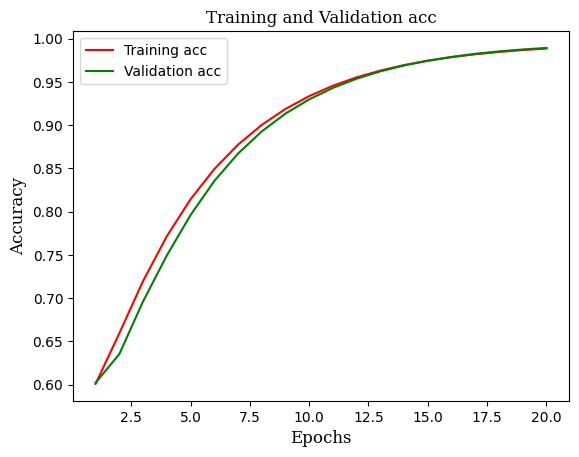

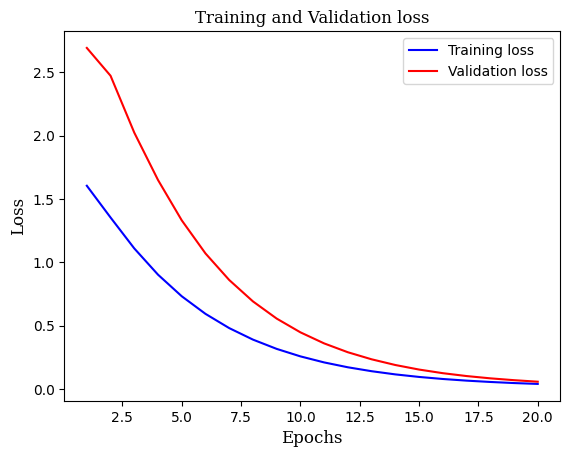

In [8]:
import matplotlib.pyplot as plt

history_dict=history.history
loss_values=history_dict['loss']
val_loss_values=history_dict['val_loss']
acc_values=history_dict['accuracy']
val_acc_values=history_dict['val_accuracy']
epochs=range(1, len(acc_values)+1)
def smooth_curve(points, factor=0.8):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points
loss_values=smooth_curve(loss_values)
val_loss_values=smooth_curve(val_loss_values)
acc_values=smooth_curve(acc_values)
val_acc_values=smooth_curve(val_acc_values)

font = {'family' : 'serif',
        'color'  : 'black',
        'weight' : 'normal',
        'size'   : 12}
        

plt.plot(epochs, acc_values, 'r-', label='Training acc')
plt.plot(epochs, val_acc_values, 'g', label='Validation acc')
plt.title('Training and Validation acc', fontdict=font)
plt.xlabel('Epochs', fontdict=font)
plt.ylabel('Accuracy', fontdict=font)
plt.legend()
plt.savefig("accuracy"+'CNN_LSTM'+".png")
plt.show()

plt.plot(epochs, loss_values, 'b-', label='Training loss')
plt.plot(epochs, val_loss_values, 'r', label='Validation loss')
plt.title('Training and Validation loss', fontdict=font)
plt.xlabel('Epochs',fontdict=font)
plt.ylabel('Loss',fontdict=font)
plt.legend()
plt.savefig("loss"+'CNN_LSTM'+".png")
plt.show()


Confusion matrix, without normalization
[[2529    1    0    1    0    0    1]
 [   0 3307    1    0    0    0    2]
 [   1    0 1956    2    0    0    3]
 [   1    3    3 2994    0    0    1]
 [   3    0    1   16 1439    0    0]
 [   6    0    2    0    0 4122    2]
 [   3    0    1    2    1    5 2578]]


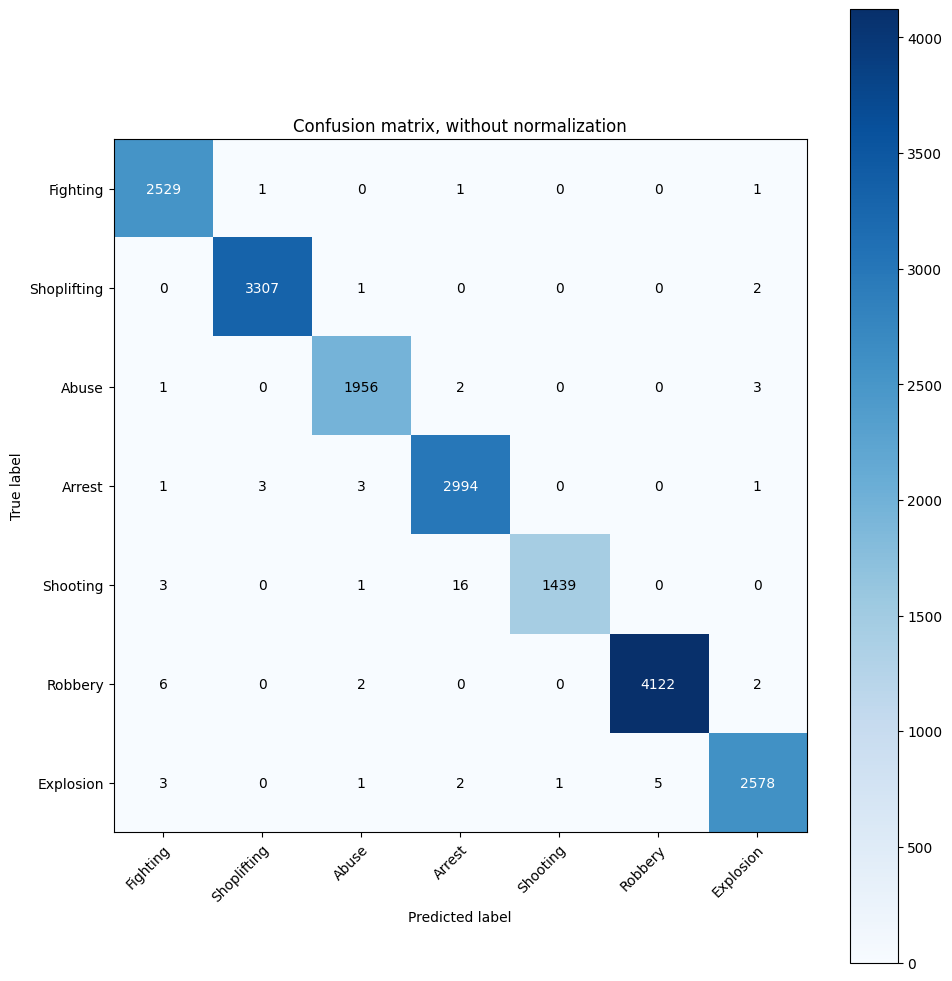

Normalized confusion matrix
[[9.99e-01 3.95e-04 0.00e+00 3.95e-04 0.00e+00 0.00e+00 3.95e-04]
 [0.00e+00 9.99e-01 3.02e-04 0.00e+00 0.00e+00 0.00e+00 6.04e-04]
 [5.10e-04 0.00e+00 9.97e-01 1.02e-03 0.00e+00 0.00e+00 1.53e-03]
 [3.33e-04 9.99e-04 9.99e-04 9.97e-01 0.00e+00 0.00e+00 3.33e-04]
 [2.06e-03 0.00e+00 6.85e-04 1.10e-02 9.86e-01 0.00e+00 0.00e+00]
 [1.45e-03 0.00e+00 4.84e-04 0.00e+00 0.00e+00 9.98e-01 4.84e-04]
 [1.16e-03 0.00e+00 3.86e-04 7.72e-04 3.86e-04 1.93e-03 9.95e-01]]


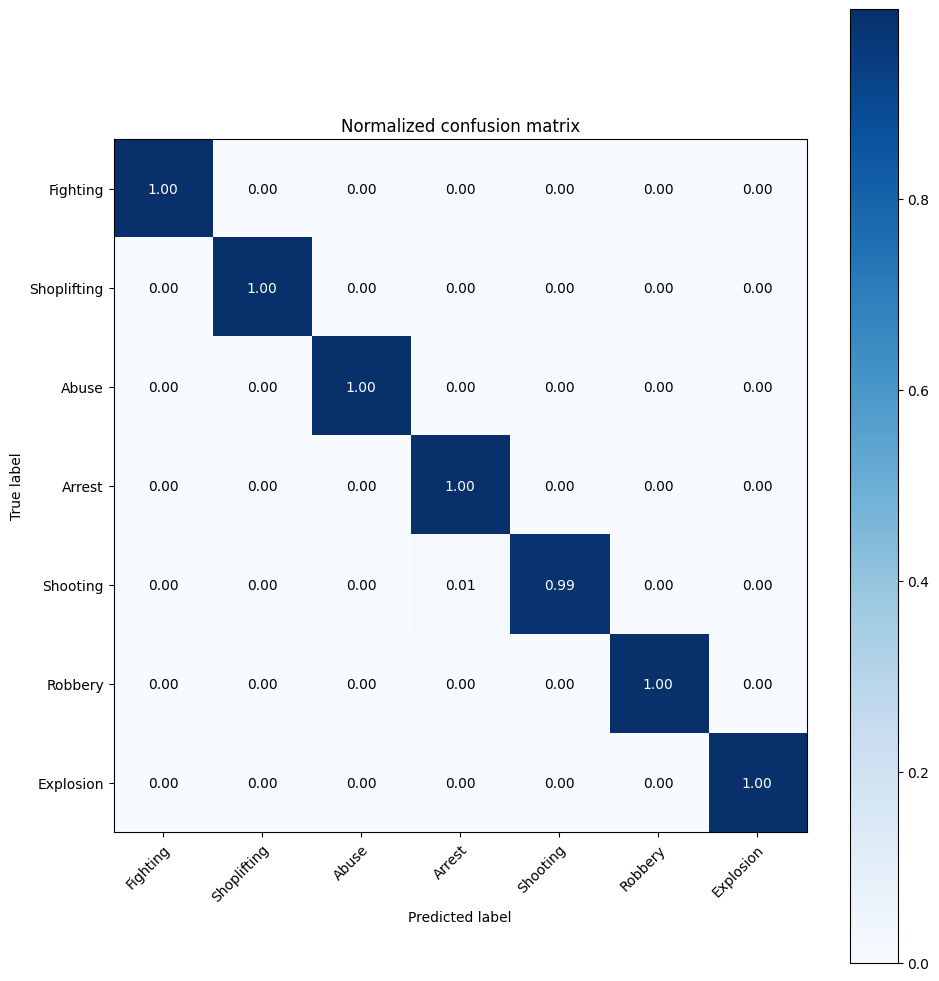

In [9]:
class_names = ['Fighting', 'Shoplifting', 'Abuse', 'Arrest', 'Shooting', 'Robbery', 'Explosion']


def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
#    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots(figsize=(10, 10))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

font = {'family' : 'serif',
        'color'  : 'black',
        'weight' : 'normal',
        'size'   : 14}

np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_true, y_pred, classes=class_names,
                      title='Confusion matrix, without normalization')
plt.savefig('confusion matrix1'+'CNN_LSTM'+'.png')
plt.show()
# Plot normalized confusion matrix
plot_confusion_matrix(y_true, y_pred, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
plt.savefig('confusion matrix2'+'CNN_LSTM'+'.png')
plt.show()

In [14]:
import cv2
import numpy as np
from keras.models import load_model

categories_labels = {'Fighting': 0, 'Shoplifting': 1, 'Abuse': 2, 'Arrest': 3, 'Shooting': 4, 'Robbery': 5, 'Explosion': 6}
labels_categories = {v: k for k, v in categories_labels.items()}  # reverse dictionary for label lookup

# Load the trained model
model = load_model('/kaggle/working/CNN_LSTM.h5')

def predict_image(image_path):
    # Load the image
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    # Resize the image
    image = cv2.resize(image, (50, 50))

    # Reshape the image to 4D array for CNN and LSTM input
    image_cnn = image.reshape((1,) + image.shape + (1,))
    image_lstm = image.reshape((1,) + (-1, 1))

    # Use the model to predict the category of the image
    prediction = model.predict([image_cnn, image_lstm])

    # Find the category with the highest probability
    label = np.argmax(prediction)

    # Return the name of the category
    return labels_categories[label]

# Test the function
image_path = "/kaggle/input/new-sample/fighting-1024x684.jpg"  # Replace with your image path
print(predict_image(image_path))


1/1 [==============================] - 1s 789ms/step
Fighting


In [15]:
#============================= this code with any image*.gif

import cv2
import numpy as np
import os
from keras.models import load_model
from PIL import Image

categories_labels = {'Fighting': 0, 'Shoplifting': 1, 'Abuse': 2, 'Arrest': 3, 'Shooting': 4, 'Robbery': 5, 'Explosion': 6}
labels_categories = {v: k for k, v in categories_labels.items()}  # reverse dictionary for label lookup

# Load the trained model
model = load_model('/kaggle/working/CNN_LSTM.h5')

def predict_image(image):
    # Resize the image
    image = cv2.resize(image, (50, 50))

    # Reshape the image to 4D array for CNN and LSTM input
    image_cnn = image.reshape((1,) + image.shape + (1,))
    image_lstm = image.reshape((1,) + (-1, 1))

    # Use the model to predict the category of the image
    prediction = model.predict([image_cnn, image_lstm])

    # Find the category with the highest probability
    label = np.argmax(prediction)

    # Return the name of the category
    return labels_categories[label]

def extract_and_predict(gif_path):
    # Open the gif image
    gif = Image.open(gif_path)

    # Extract all frames from the gif
    frames = []
    try:
        while True:
            gif.seek(gif.tell() + 1)
            frames.append(np.array(gif.convert('L')))  # Convert image to grayscale
    except EOFError:
        pass  # end of sequence

    # Predict the category of each frame and save it in a new directory
    new_dir = 'predicted_images'
    os.makedirs(new_dir, exist_ok=True)
    last_category = None  # variable to keep track of the last predicted category
    for i, frame in enumerate(frames):
        category = predict_image(frame)
        if category != last_category:  # only print the category if it's different from the last one
            print('Frame', i, 'Category:', category)
        last_category = category  # update the last predicted category
        cv2.imwrite(os.path.join(new_dir, f'{category}_{i}.png'), frame)

# Test the function
gif_path = "/kaggle/input/new-gif/sam.gif"  # Replace with your gif path
extract_and_predict(gif_path)

#0 to 208 Robbery, then 209-210 arrest, then ..........

1/1 [==============================] - 1s 798ms/step
Frame 0 Category: Robbery
1/1 [==============================] - 0s 63ms/step
Frame 183 Category: Arrest
1/1 [==============================] - 0s 67ms/step
Frame 184 Category: Robbery
1/1 [==============================] - 0s 67ms/step
Frame 185 Category: Arrest
1/1 [==============================] - 0s 63ms/step
Frame 186 Category: Robbery
1/1 [==============================] - 0s 101ms/step
Frame 209 Category: Arrest
1/1 [==============================] - 0s 97ms/step
Frame 211 Category: Robbery
1/1 [==============================] - 0s 82ms/step
Frame 215 Category: Arrest
1/1 [==============================] - 0s 74ms/step
Frame 217 Category: Robbery
1/1 [==============================] - 0s 70ms/step
Frame 219 Category: Arrest
1/1 [==============================] - 0s 68ms/step
Frame 222 Category: Robbery
1/1 [==============================] - 0s 65ms/step
Frame 229 Category: Arrest
1/1 [==============================] - 0s 63ms